# Editing graph state

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

### Editing state

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_groq import ChatGroq

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatGroq(model=os.getenv("GROQ_MODEL_NAME"))
llm_with_tools = llm.bind_tools(tools)

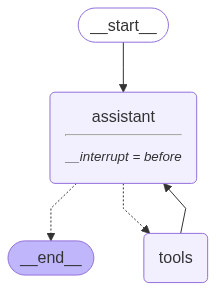

In [4]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [5]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id":"2"}}

# Run the graph until the first interptution
for envent in graph.stream(initial_input , thread , stream_mode="values"):
    envent["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [6]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='320f7854-04f6-4a79-8b3f-d7586480a52e')]}, next=('assistant',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f02ff65-0892-6e08-8000-d74caf20de79'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}, 'thread_id': '2'}, created_at='2025-05-13T12:32:20.811309+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f02ff65-0890-6da6-bfff-c06a03b75df0'}}, tasks=(PregelTask(id='5711b2aa-9e22-cfc7-c0fb-3c82dc2cf232', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [7]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually multiply 3 and 3!")]},
)

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f02ff65-094c-6f7e-8001-275cddb6ad64'}}

In [8]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually multiply 3 and 3!


In [9]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_4p20)
 Call ID: call_4p20
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


In [10]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

The result of multiplying 3 and 3 is 9.


In [11]:
# This is the URL of the local development server
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

In [12]:
initial_input = {"messages": "Multiply 2 and 3"}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'b7d0ba71-088a-40d0-9c84-2603eb2bab30', 'example': False}
--------------------------------------------------


In [13]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'messages': [{'content': 'Multiply 2 and 3',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'b7d0ba71-088a-40d0-9c84-2603eb2bab30',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': 'c850cbb3-32d9-02fa-fc48-abcf03171a97',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': None}],
 'metadata': {'user-agent': 'langgraph-sdk-py/0.1.69',
  'x-request-id': '68c63483-5d1f-44c8-859c-d98449245a84',
  'langgraph_auth_user': None,
  'langgraph_auth_user_id': '',
  'langgraph_auth_permissions': [],
  'langgraph_request_id': '68c63483-5d1f-44c8-859c-d98449245a84',
  'graph_id': 'agent',
  'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'user_id': '',
  'created_by': 'system',
  'run_attempt': 1,
  'langgraph_version': '0.4.3',
  'langgraph_plan': 'developer',
  'langgraph_host': 'self-hosted',

In [14]:
last_message = current_state['values']['messages'][-1]
last_message

{'content': 'Multiply 2 and 3',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': 'b7d0ba71-088a-40d0-9c84-2603eb2bab30',
 'example': False}

In [15]:
last_message['content'] = "No, actually multiply 3 and 3!"
last_message

{'content': 'No, actually multiply 3 and 3!',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': 'b7d0ba71-088a-40d0-9c84-2603eb2bab30',
 'example': False}

In [16]:
last_message

{'content': 'No, actually multiply 3 and 3!',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': 'b7d0ba71-088a-40d0-9c84-2603eb2bab30',
 'example': False}

In [17]:
await client.threads.update_state(thread['thread_id'], {"messages": last_message})

{'checkpoint': {'thread_id': 'fbdb7496-cb04-46f5-809b-1df264b20b4d',
  'checkpoint_ns': '',
  'checkpoint_id': '1f02ff65-15d5-60de-8001-6d6f55d0542a'},
 'configurable': {'thread_id': 'fbdb7496-cb04-46f5-809b-1df264b20b4d',
  'checkpoint_ns': '',
  'checkpoint_id': '1f02ff65-15d5-60de-8001-6d6f55d0542a'},
 'checkpoint_id': '1f02ff65-15d5-60de-8001-6d6f55d0542a'}

In [18]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'No, actually multiply 3 and 3!', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'b7d0ba71-088a-40d0-9c84-2603eb2bab30', 'example': False}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_xy2y', 'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'token_usage': {'completion_tokens': 19, 'prompt_tokens': 378, 'total_tokens': 397, 'completion_time': 0.069090909, 'prompt_time': 0.02435025, 'queue_time': 0.06160526999999999, 'total_time': 0.093441159}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--90246b6c-bb00-426b-95bc-8a1

In [19]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '9', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': 'a6471cc8-f5d3-4f00-b545-fe50742bf3d3', 'tool_call_id': 'call_xy2y', 'artifact': None, 'status': 'success'}
--------------------------------------------------
Receiving new event of type: values...
{'content': 'The result of multiplying 3 and 3 is 9.', 'additional_kwargs': {}, 'response_metadata': {'token_usage': {'completion_tokens': 14, 'prompt_tokens': 408, 'total_tokens': 422, 'completion_time': 0.050909091, 'prompt_time': 0.026555983, 'queue_time': 0.05911386700000001, 'total_time': 0.077465074}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'stop', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--de58d457-d41d-445f-9280-ed4be24144d7-0', 'example': False, 'tool_calls': [], 'invalid_too

### Awaiting user input

In [21]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

# Assistant node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph after 1 retries. To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [23]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()
    
# Get user input
user_input = input("Tell me how you want to update the state: ")

# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

no, multiply 3 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_80aq)
 Call ID: call_80aq
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


In [24]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

The result of multiplying 3 and 3 is 9.
